# Portland Trail Blazers - Extended Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 01, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the extended list of PTB features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 5 # Portland Trail Blazers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27466 entries, 0 to 27465
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              27466 non-null  int64  
 1   dimCustomerMasterId       27466 non-null  int64  
 2   customerNumber            27466 non-null  object 
 3   year                      27466 non-null  object 
 4   productGrouping           27466 non-null  object 
 5   totalSpent                27466 non-null  float64
 6   recentDate                27466 non-null  object 
 7   attendancePercent         27466 non-null  float64
 8   renewedBeforeDays         27466 non-null  int64  
 9   isBuyer                   27466 non-null  object 
 10  source_tenure             27466 non-null  int64  
 11  tenure                    27466 non-null  int64  
 12  distToVenue               0 non-null      object 
 13  totalGames                27466 non-null  int64  
 14  recenc

In [5]:
df.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,tenure,distToVenue,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,fill_out_form,open_email,send_email,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,posting_records,resale_records,resale_atp,forward_records,cancel_records,email,inbound_email,inbound_phonecall,inperson_contact,internal_note,left_message,outbound_email,outbound_phonecall,phonecall,text,unknown,gender,childrenPresentInHH,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,isnextyear_buyer,isnextyear_samepkg_buyer,pkgupgrade_status,auto_renewal,credits_after_refund,isNextYear_Buyer
0,5,1335,1074005,2017,Full Season,1584.00,2018-04-11,0.813953,239,TRUE,5475,429,None,35,0,3,3,0,88,12,600,780,0,0.769231,0.112821,0.146667,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,None,None,None,None,0.0,1
1,5,2847,200593940,2017,Mini Plan,183.00,2018-03-30,0.727273,21,TRUE,2555,197,None,2,0,1,0,0,32,0,24,328,0,0.073171,0.097561,1.333333,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,None,None,None,None,0.0,1
2,5,3475,412379,2017,Full Season,1028.72,2018-04-11,0.813953,239,TRUE,6570,429,None,35,0,5,0,1,0,8,0,12,0,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,None,None,None,None,0.0,1
3,5,3871,190351852,2017,Full Season,7942.00,2018-04-11,1.000000,183,TRUE,4015,373,None,43,0,1,0,0,68,0,240,740,0,0.324324,0.091892,0.283333,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,None,None,None,None,0.0,0
4,5,4439,190382859,2017,Full Season,3553.44,2018-04-11,1.000000,239,TRUE,3285,429,None,43,0,1,0,0,428,40,652,992,0,0.657258,0.431452,0.656442,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,None,None,None,None,0.0,1


### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [11]:
# choose the features for the ptb extended retention model
features = [
    "annualHHIncome",
    "attendancePercent",
    "cancel_records",
    "childrenPresentInHH", 
    "clickToOpenRatio", 
    "clickToSendRatio",
    "dimCustomerMasterId",
    "distToVenue",
    "education",
    "fill_out_form",
    "forward_records",
    "gender",
    "isNextYear_Buyer",
    "lengthOfResidenceInYrs",
    "maritalStatus",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "posting_records",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "resale_atp",
    "resale_records",
    "source_tenure",
    "tenure",
    "totalSpent",
    "year"
]

# select % of the data for training
df_train = df.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df.drop(df_train.index).reset_index(drop=True)

# choose features for each train dataset
df_train = df_train[features]

# choose features for each train dataset
df_eval = df_eval[features]

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (21973, 29)
Unseen Data For Predictions: (5493, 29)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [12]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    numeric_features=[
        "annualHHIncome",
        "attendancePercent",
        "cancel_records",
        "childrenPresentInHH", 
        "clickToOpenRatio", 
        "clickToSendRatio",
        "distToVenue",
        "fill_out_form",
        "forward_records",
        "lengthOfResidenceInYrs",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "openToSendRatio",
        "posting_records",
        "recency",
        "renewedBeforeDays",
        "resale_atp",
        "resale_records",
        "source_tenure",
        "tenure",
        "totalSpent"
    ]
);

In [13]:
# adding an extra classifier xgboost
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8281,0.9134,0.8635,0.8118,0.8368,0.6556,0.6571,0.6240


### The top model is performing well, so let's compare it against our unseen eval dataset:

In [14]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8373,0.9153,0.8506,0.8339,0.8422,0.6744,0.6745
1,0.8146,0.9040,0.8651,0.7910,0.8264,0.6282,0.6311
2,0.8333,0.9200,0.8584,0.8226,0.8402,0.6662,0.6669
3,0.8248,0.9111,0.8618,0.8077,0.8339,0.6490,0.6505
4,0.8180,0.9053,0.8573,0.8002,0.8278,0.6353,0.6370
5,0.8299,0.9138,0.8774,0.8064,0.8404,0.6591,0.6618
6,0.8316,0.9182,0.8651,0.8160,0.8398,0.6627,0.6639
7,0.8225,0.9124,0.8473,0.8128,0.8297,0.6446,0.6452
8,0.8264,0.9115,0.8662,0.8077,0.8359,0.6521,0.6539
9,0.8423,0.9225,0.8862,0.8194,0.8515,0.6840,0.6864


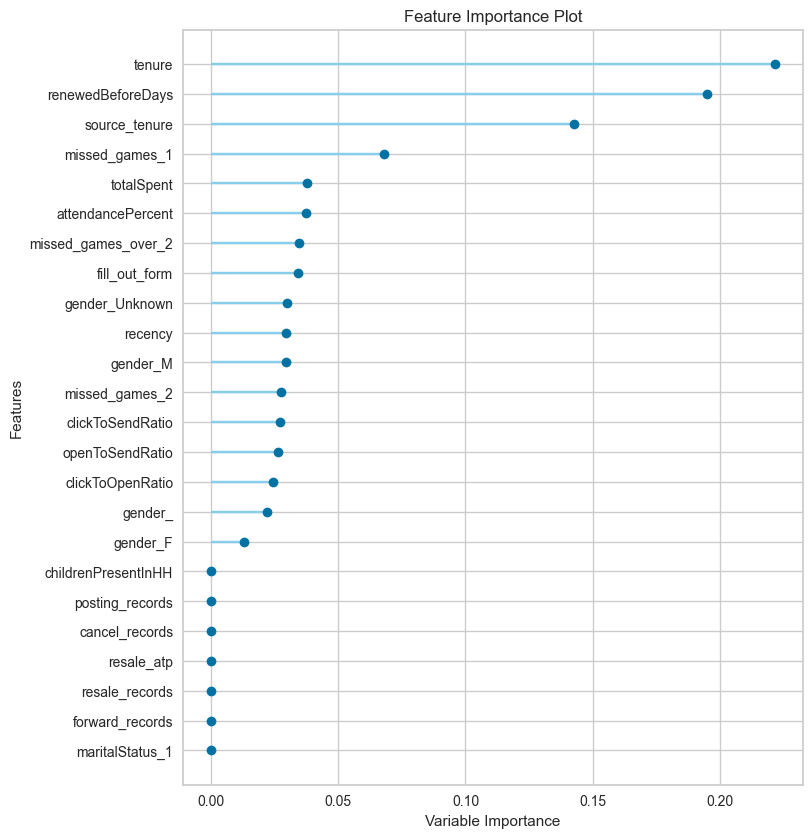

In [16]:
plot_model(best_model, plot='feature_all')

In [ ]:
plot_model(best_model, plot='confusion_matrix')

## Observations
* Compared to the standard StellarAlgo retention features, the extended PTB features increased accuracy from 0.8825 to 0.9098.
* An additional feature (clickToOpenRatio) registers as the highest feature along with tenure for retention prediction.
* The extended feature model was better at predicting buyers who don't renew.

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?